# Importing the necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.preprocessing import image

## Getting the path of the training and testing data of the cell image dataset

In [2]:
dataset_directory_location = 'cell_images'

In [3]:
os.listdir(dataset_directory_location)

['test', 'train']

In [4]:
train_dataset_location = os.path.join(dataset_directory_location, 'train')
test_dataset_location = os.path.join(dataset_directory_location, 'test')

In [5]:
os.listdir(train_dataset_location)

['parasitized', 'uninfected']

In [6]:
os.listdir(test_dataset_location)

['parasitized', 'uninfected']

## Viewing a cell image

In [7]:
cell_image_sample = os.path.join(train_dataset_location, 'Parasitized')

In [8]:
os.listdir(cell_image_sample)[:1]

['C33P1thinF_IMG_20150619_114756a_cell_179.png']

In [9]:
cell_image_sample_read = imread(os.path.join(cell_image_sample, 'C33P1thinF_IMG_20150619_114756a_cell_179.png'))

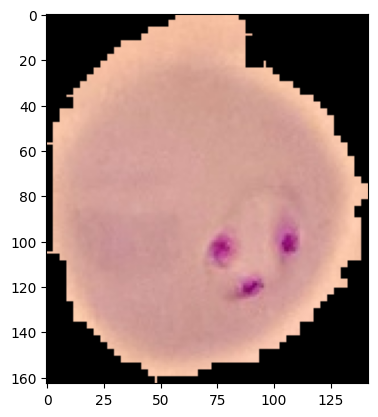

In [10]:
plt.imshow(cell_image_sample_read)

In [11]:
cell_image_sample_read.shape 

(163, 142, 3)

## Defining the correct shape of the image

In [12]:
correct_image_shape = (224, 224, 3)

## Defining the ImageGenerator and performing Data Augmentation

In [13]:
image_gen = ImageDataGenerator(rotation_range=20, 
                               width_shift_range=0.1, 
                               height_shift_range=0.1, 
                               shear_range=0.1, 
                               zoom_range=0.1, 
                               horizontal_flip=True, 
                               fill_mode='nearest',
                               rescale=1./255)

In [14]:
train_image_gen = image_gen.flow_from_directory(train_dataset_location, 
                                                target_size=correct_image_shape[:2], 
                                                color_mode='rgb', 
                                                batch_size=16, 
                                                class_mode='binary')

test_image_gen = image_gen.flow_from_directory(test_dataset_location, 
                                                target_size=correct_image_shape[:2], 
                                                color_mode='rgb', 
                                                batch_size=16, 
                                                class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Defining the early stop

In [15]:
early_stop_loss = EarlyStopping(monitor='loss', patience=2)
early_stop_val_loss = EarlyStopping(monitor='val_loss', patience=2)

## Creating and training the model

In [16]:
model = Sequential()

In [17]:
model.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', padding='valid', input_shape=correct_image_shape))

model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="valid"))


model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="valid"))

model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="valid"))


model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="valid"))


model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="valid"))


model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="valid"))

model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="valid"))


model.add(Flatten())


model.add(Dense(4096, activation='relu'))

model.add(Dropout(0.4))

model.add(Dense(4096, activation='relu'))

model.add(Dropout(0.4))


model.add(Dense(1, activation='sigmoid'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 384)         1

In [19]:
model.compile(loss=BinaryCrossentropy(), optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

In [20]:
model.fit(train_image_gen, validation_data=test_image_gen, epochs=30, callbacks=[early_stop_loss, early_stop_val_loss])

Epoch 1/30
625/625 [==============================] - 189s 272ms/step - loss: 0.6661 - accuracy: 0.5778 - val_loss: 0.7152 - val_accuracy: 0.5220
Epoch 2/30
625/625 [==============================] - 161s 257ms/step - loss: 0.5500 - accuracy: 0.7250 - val_loss: 0.5128 - val_accuracy: 0.7335
Epoch 3/30
625/625 [==============================] - 160s 256ms/step - loss: 0.4431 - accuracy: 0.7849 - val_loss: 0.4094 - val_accuracy: 0.8040
Epoch 4/30
625/625 [==============================] - 158s 252ms/step - loss: 0.3664 - accuracy: 0.8405 - val_loss: 0.3422 - val_accuracy: 0.8570
Epoch 5/30
625/625 [==============================] - 179s 286ms/step - loss: 0.3286 - accuracy: 0.8646 - val_loss: 0.3148 - val_accuracy: 0.8720
Epoch 6/30
625/625 [==============================] - 175s 280ms/step - loss: 0.3037 - accuracy: 0.8748 - val_loss: 0.2907 - val_accuracy: 0.8825
Epoch 7/30
625/625 [==============================] - 165s 264ms/step - loss: 0.2858 - accuracy: 0.8873 - val_loss: 0.2901 -

In [21]:
history_df = pd.DataFrame(model.history.history)

<Axes: >

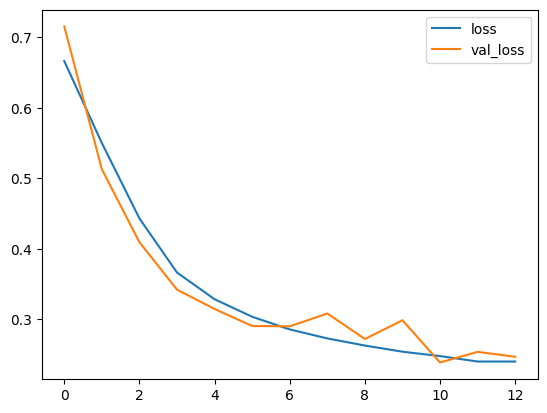

In [22]:
history_df[['loss', 'val_loss']].plot()

<Axes: >

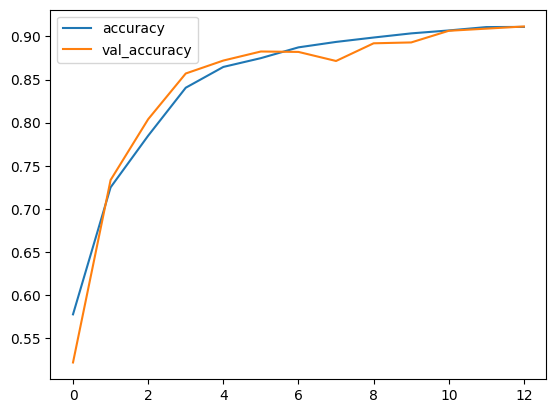

In [23]:
history_df[['accuracy', 'val_accuracy']].plot()

## Evaluating the model

In [24]:
model.evaluate(train_image_gen)[1]

625/625 [==============================] - 133s 213ms/step - loss: 0.2480 - accuracy: 0.9106


0.9106000065803528

In [25]:
model.evaluate(test_image_gen)[1]

125/125 [==============================] - 26s 211ms/step - loss: 0.2537 - accuracy: 0.9110


0.9110000133514404

## Predicting on a sample image

In [26]:
sample_img_load = image.load_img('./cell_images/test/parasitized/C100P61ThinF_IMG_20150918_145609_cell_149.png', target_size=correct_image_shape)

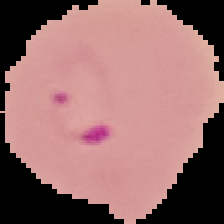

In [27]:
sample_img_load

In [28]:
sample_img_to_arr = image.img_to_array(sample_img_load) 

In [29]:
sample_img_to_arr = image.img_to_array(sample_img_load) / 255

In [30]:
sample_img_to_arr_expand_dim = np.expand_dims(sample_img_to_arr, 0) 

In [31]:
prediction = (model.predict(sample_img_to_arr_expand_dim) > 0.5).astype('int32')

1/1 [==============================] - 1s 739ms/step


In [32]:
class_names = ['parasitized', 'uninfected']

In [33]:
pred_final_result = class_names[prediction[0][0]]

In [34]:
pred_final_result

'parasitized'

## Save the model

In [35]:
save_model(model, 'alexnet_model')

INFO:tensorflow:Assets written to: alexnet_model\assets


INFO:tensorflow:Assets written to: alexnet_model\assets
